# Tutorial 10: Multi-sample integration task for mouse brain data

In this tutorial, we demonstrate how to integrate multiple samples of mouse brain data vertically using STGMVA.

You can download the two sections of mouse brain data at https://zenodo.org/record/8141084.

This data is stored in "8. Mouse brain_batch effects" folder.

STGMVA could remove the batch effects and identify the cell types in the integrated data.


## Loading package

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

In [2]:
from STGMVA.STGMVA import STGMMVE
from STGMVA import mk_dir

2023-07-15 17:15:24.324353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Reading ST data and showing two sections of mouse brain data

In [3]:
# load section1
file_fold = '/home/tengliu/Paper6-NC/STGMVA_Tutorials/ST data/8. Mouse brain_batch effects/Section1'
adata1 = sc.read_visium(file_fold, count_file='V1_Adult_Mouse_Brain_Coronal_Section_1_filtered_feature_bc_matrix.h5', load_images=True)
adata1.var_names_make_unique()

# load section2
file_fold = '/home/tengliu/Paper6-NC/STGMVA_Tutorials/ST data/8. Mouse brain_batch effects/Section2'
adata2 = sc.read_visium(file_fold, count_file='V1_Adult_Mouse_Brain_Coronal_Section_2_filtered_feature_bc_matrix.h5', load_images=True)
adata2.var_names_make_unique()

adata = ad.concat([adata1,adata2],label="data")
adata.obs['data'].replace({'0':'Section 1', '1':'Section 2'}, inplace=True)

In [4]:
adata

AnnData object with n_obs × n_vars = 5710 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    obsm: 'spatial'

<Axes: title={'center': 'data'}, xlabel='spatial1', ylabel='spatial2'>

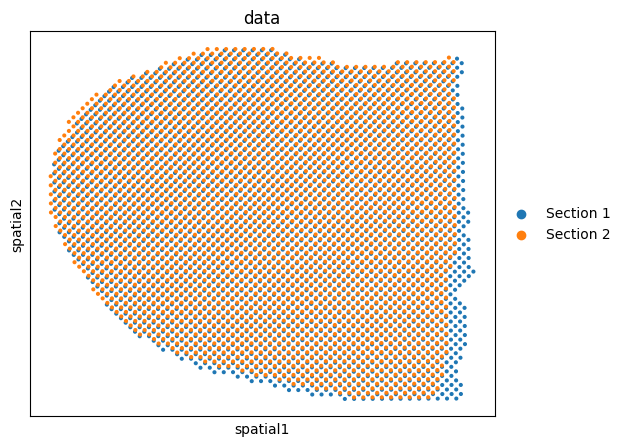

In [5]:
plt.rcParams["figure.figsize"] = (6, 5)
sc.pl.embedding(adata, basis='spatial',size=35, 
                # palette ='viridis',
                color='data',show=False) #vlag, icefire, viridis

## Create directory for pretrained model

In [6]:
save_path='./Samp_results/'
section_id = "mouse_brain2_batch"
mk_dir(save_path,section_id)

## Training the model

STGMVA aims to learn the representations by two-step process. First, pretrained the GMM clustering model. Second, discerned the spatial domains for spatial transcriptomics data. 

After model training, the learned representations will be saved in adata.obsm['embedding'], and can be used for spatial clustering. 

In [7]:
model = STGMMVE(adata, datatype="mouse_brain2", nCluster=8,save_path=save_path, section_id=section_id)

# model.pretrain() # Train your own pretranined model or use the pretrained model we provided.

adata_res = model.train_cluster()


Graph constructed!


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


  0%|          | 0/50 [00:11<?, ?it/s]

Epoch: 0
NMI=0.627154, ARI=0.465271
Loss=25.7184,  ELBO Loss=65.6800


 10%|█         | 5/50 [01:00<07:12,  9.60s/it]

Epoch: 5
NMI=0.616150, ARI=0.456283
Loss=27.6566,  ELBO Loss=50.9886


 20%|██        | 10/50 [01:56<06:56, 10.41s/it]

Epoch: 10
NMI=0.626796, ARI=0.459680
Loss=27.8410,  ELBO Loss=45.3978


 30%|███       | 15/50 [02:45<06:26, 11.05s/it]

Epoch: 15
NMI=0.620105, ARI=0.437321
Loss=27.6282,  ELBO Loss=42.8611


 40%|████      | 20/50 [03:35<04:35,  9.19s/it]

Epoch: 20
NMI=0.628982, ARI=0.472545
Loss=27.4959,  ELBO Loss=41.7353


 50%|█████     | 25/50 [04:20<04:11, 10.07s/it]

Epoch: 25
NMI=0.612770, ARI=0.457316
Loss=27.1771,  ELBO Loss=40.8897


 60%|██████    | 30/50 [05:10<02:57,  8.86s/it]

Epoch: 30
NMI=0.614638, ARI=0.459332
Loss=27.0467,  ELBO Loss=40.2724


 70%|███████   | 35/50 [05:56<02:36, 10.43s/it]

Epoch: 35
NMI=0.611849, ARI=0.456538
Loss=26.9236,  ELBO Loss=39.7616


 80%|████████  | 40/50 [06:48<01:34,  9.43s/it]

Epoch: 40
NMI=0.582316, ARI=0.419671
Loss=26.9343,  ELBO Loss=39.3927


 90%|█████████ | 45/50 [07:34<00:52, 10.51s/it]

Epoch: 45
NMI=0.577671, ARI=0.415394
Loss=26.8497,  ELBO Loss=39.0086


100%|██████████| 50/50 [08:16<00:00,  9.93s/it]


In [8]:
adata_res

AnnData object with n_obs × n_vars = 5710 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'pre_label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'data_colors', 'hvg', 'log1p', 'mclust_labels', 'ari_list', 'loss'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'feat_mat', 'embedding'

## Visualization

### Batch effect removal figure

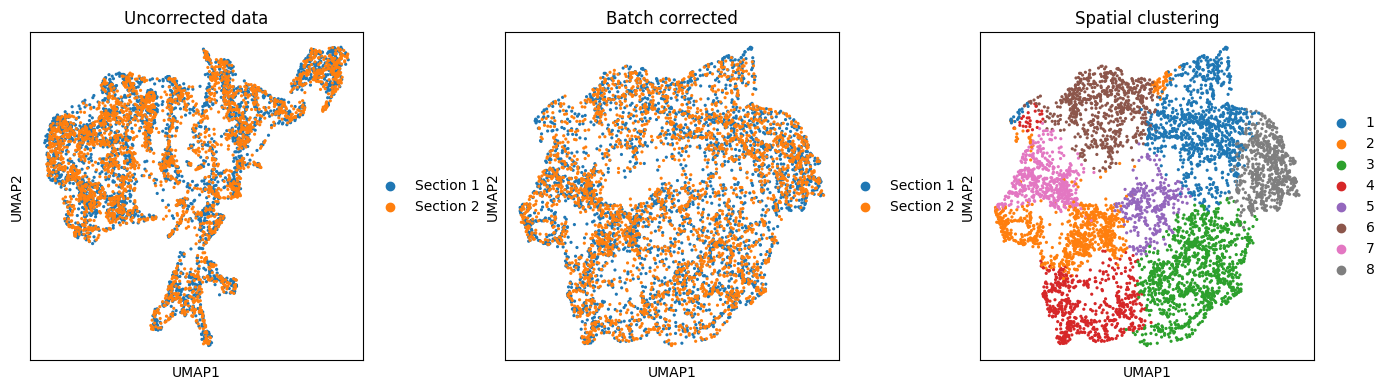

In [10]:
from STGMVA import batch_effect
batch_effect(adata_res)

### Spatial clustering for two sections

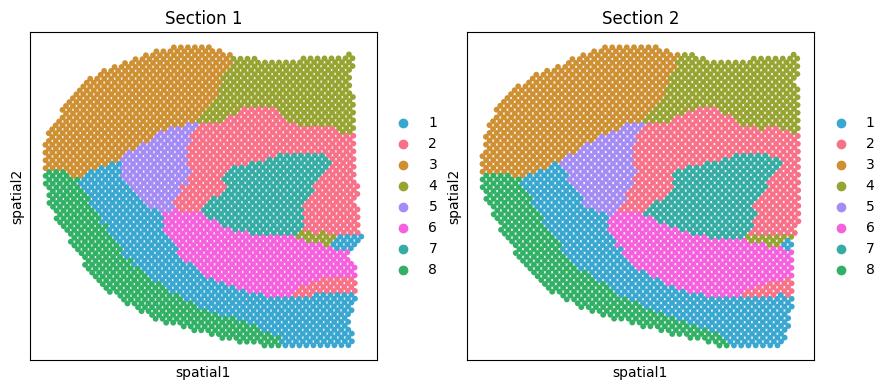

In [11]:
from STGMVA import split_cluster
split_cluster(adata_res)

### save the results for more figures

In [12]:
adata_res.filename = './'+"mouse_brain2_batch_effect.h5ad"